In [3]:
include("./prepare_data.jl")
include("./model.jl")

import .Model
import Flux

In [30]:
using CUDA 
device = Flux.gpu

flux_model = Model.model |> device

Chain(
  Recur(
    LSTMCell(3 => 32),                  # 4_672 parameters
  ),
  Recur(
    LSTMCell(32 => 16),                 # 3_168 parameters
  ),
  Flux.flatten,
  Dense(8192 => 3),                     # 24_579 parameters
  NNlib.softmax,
)         # Total: 12 trainable arrays, 32_419 parameters,
          # plus 4 non-trainable, 96 parameters, summarysize 1.727 KiB.

In [31]:
function flux_loss(model, x, y)
    ŷ = model(x)
    Flux.crossentropy(ŷ, y)
end

flux_loss (generic function with 1 method)

In [32]:
using ProgressMeter
using MLUtils 

data_loader = MLUtils.DataLoader(DataSet(ModelCfgs.D), batchsize=32) |> device
 opt_state  = Flux.setup(Flux.Adam(0.0001),flux_model)


(layers = ((cell = (Wi = Leaf(Adam{Float64}(0.0001, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], Float32[0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], (0.9, 0.999))), Wh = Leaf(Adam{Float64}(0.0001, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), b = Leaf(Adam{Float64}(0.0001, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), state0 = (Leaf(Adam{Float64}(0.0001, (0.9, 0.999), 1.0e-8), (Float32[0.0; 0.0; … ; 0.0; 0.0;;], Float32[0.0; 0.0; … ; 0.0; 0.0;;], (0.9, 0.999))), Leaf(Adam{Float64}(0.0001, (0.9, 0.999), 1.0e-8), (Float32[0.0; 0.0; … ; 0.0; 0.0;;], 

In [33]:
losses = []
epochs = 50
@showprogress for epoch in 1:epochs 
                    total_loss = 0.0
                    for (x,y) in data_loader
                        l = flux_loss(flux_model, x, y)
                        total_loss += l
                        Flux.train!(flux_loss, flux_model, [(x, y)], opt_state)
                    end
                    push!(losses,total_loss)
end

Progress:   4%|██                                       |  ETA: 0:02:50

Progress:   6%|███                                      |  ETA: 0:02:30

Progress:   8%|████                                     |  ETA: 0:02:18

Progress:  10%|█████                                    |  ETA: 0:02:10

Progress:  12%|█████                                    |  ETA: 0:02:04

Progress:  14%|██████                                   |  ETA: 0:01:58

Progress:  16%|███████                                  |  ETA: 0:01:54

Progress:  18%|████████                                 |  ETA: 0:01:50

Progress:  20%|█████████                                |  ETA: 0:01:46

Progress:  22%|██████████                               |  ETA: 0:01:43

Progress:  24%|██████████                               |  ETA: 0:01:39

Progress:  26%|███████████                              |  ETA: 0:01:36

Progress:  28%|████████████                             |  ETA: 0:01:33

Progress:  30%|█████████████                            |  ETA: 0:01:30

Progress:  32%|██████████████                           |  ETA: 0:01:27

Progress:  34%|██████████████                           |  ETA: 0:01:24

Progress:  36%|███████████████                          |  ETA: 0:01:21

Progress:  38%|████████████████                         |  ETA: 0:01:19

Progress:  40%|█████████████████                        |  ETA: 0:01:16

Progress:  42%|██████████████████                       |  ETA: 0:01:13

Progress:  44%|███████████████████                      |  ETA: 0:01:11

Progress:  46%|███████████████████                      |  ETA: 0:01:08

Progress:  48%|████████████████████                     |  ETA: 0:01:05

Progress:  50%|█████████████████████                    |  ETA: 0:01:03

Progress:  52%|██████████████████████                   |  ETA: 0:01:00

Progress:  54%|███████████████████████                  |  ETA: 0:00:57

Progress:  56%|███████████████████████                  |  ETA: 0:00:55

Progress:  58%|████████████████████████                 |  ETA: 0:00:52

Progress:  60%|█████████████████████████                |  ETA: 0:00:50

Progress:  62%|██████████████████████████               |  ETA: 0:00:47

Progress:  64%|███████████████████████████              |  ETA: 0:00:45

Progress:  66%|████████████████████████████             |  ETA: 0:00:42

Progress:  68%|████████████████████████████             |  ETA: 0:00:40

Progress:  70%|█████████████████████████████            |  ETA: 0:00:37

Progress:  72%|██████████████████████████████           |  ETA: 0:00:35

Progress:  74%|███████████████████████████████          |  ETA: 0:00:32

Progress:  76%|████████████████████████████████         |  ETA: 0:00:30

Progress:  78%|████████████████████████████████         |  ETA: 0:00:27

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:25

Progress:  82%|██████████████████████████████████       |  ETA: 0:00:22

Progress:  84%|███████████████████████████████████      |  ETA: 0:00:20

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:17

Progress:  88%|█████████████████████████████████████    |  ETA: 0:00:15

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:12

Progress:  92%|██████████████████████████████████████   |  ETA: 0:00:10

Progress:  94%|███████████████████████████████████████  |  ETA: 0:00:07

Progress:  96%|████████████████████████████████████████ |  ETA: 0:00:05

Progress:  98%|█████████████████████████████████████████|  ETA: 0:00:02

Progress: 100%|█████████████████████████████████████████| Time: 0:02:02


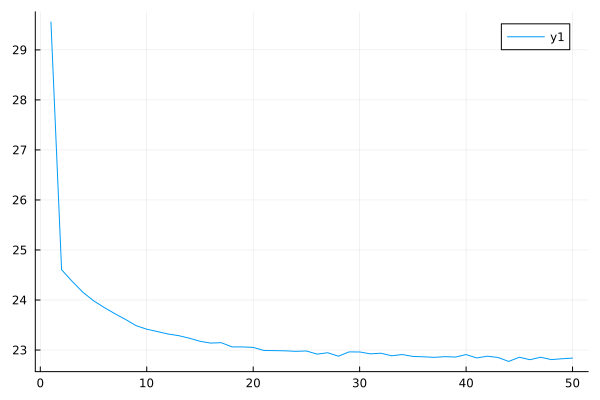

In [34]:
import Plots

Plots.plot(losses)

In [5]:
date_now = 5

5

In [36]:
io = open(string("./output/losses_",ModelCfgs.D,"_",date_now,".txt"),"w")
    for loss in losses 
        println(io,loss)
    end
close(io)

In [37]:
cpu_model = Flux.cpu(flux_model)

using BSON: @save
@save string("./output/mymodel_",ModelCfgs.D,"_",date_now,".bson") cpu_model

In [6]:
using Flux, BSON
BSON.@load string("./output/mymodel_$(ModelCfgs.D)_",date_now,".bson") cpu_model

In [41]:
cpu_model = Flux.cpu(flux_model)

Chain(
  Recur(
    LSTMCell(3 => 32),                  # 4_672 parameters
  ),
  Recur(
    LSTMCell(32 => 16),                 # 3_168 parameters
  ),
  Flux.flatten,
  Dense(8192 => 3),                     # 24_579 parameters
  NNlib.softmax,
)         # Total: 12 trainable arrays, 32_419 parameters,
          # plus 4 non-trainable, 49_152 parameters, summarysize 319.590 KiB.

In [43]:
Flux.params(cpu_model)

Params([Float32[0.0650337 -0.05625801 -0.20979801; 0.067811474 -0.00074139243 0.16612074; … ; -0.08719223 -0.16666235 0.0077363444; 0.07778177 -0.081024975 -0.013297565], Float32[-0.08958635 -0.09364281 … 0.051046483 -0.1074993; -0.13679382 -0.019218294 … 0.11988527 -0.11770011; … ; 0.0708203 -0.008360626 … -0.14308523 0.0012270676; 0.16647737 -0.008177981 … -0.0027759464 -0.04906301], Float32[-0.0053818994, 0.0015517654, -0.0043855044, -0.0017560734, 0.0005418071, -0.004889137, -0.0076855114, 0.009650614, 0.0022684173, 0.0011302921  …  0.00015253766, 0.00141148, -0.0050232597, -0.00070988084, -0.00039954693, -0.0023853565, 0.006099094, -0.0068570855, -0.004545181, 0.0074984594], Float32[0.0; 0.0; … ; 0.0; 0.0;;], Float32[0.0; 0.0; … ; 0.0; 0.0;;], Float32[-0.2018819 0.22097838 … 0.069937564 -0.0015294589; 0.18300688 0.069136366 … -0.040219977 -0.15350205; … ; -0.027393183 -0.21524669 … 0.16641349 -0.05165789; -0.005190822 0.18471913 … 0.14718677 0.056152496], Float32[0.21771675 -0.131

In [19]:
# calculate accuracy
function accuracy(model, x, y)
   ŷ = Flux.cpu(model(x))
#    @show size(ŷ)
#    @show argmax(ŷ, dims=1) |> size 
    y = Flux.cpu(y)  
    
    
    acc = sum(argmax(ŷ, dims=1) .== argmax(y, dims=1)) / length(y)
    acc
end

function accuracy(model, data_loader)
    acc = 0.0
    for (x,y) in data_loader
        
        acc += accuracy(model, x, y)

        
    end
    acc / length(data_loader)
end


accuracy (generic function with 2 methods)

In [15]:
using ProgressMeter
using MLUtils 

data_loader = MLUtils.DataLoader(DataSet(ModelCfgs.D), batchsize=32) 


41-element DataLoader(::DataSet, batchsize=32)
  with first element:
  (3×512×32 Array{Float64, 3}, 3×32 Matrix{Int64},)

In [20]:

accuracy(cpu_model, data_loader)


0.2559929459588713

In [23]:
data_loader2 = MLUtils.DataLoader(DataSet(ModelCfgs.D), batchsize=32) 
baseline_model = Model.model 
accuracy(baseline_model, data_loader2)

0.003810975609756097

In [22]:
baseline_model

Chain(
  Recur(
    LSTMCell(3 => 32),                  # 4_672 parameters
  ),
  Recur(
    LSTMCell(32 => 16),                 # 3_168 parameters
  ),
  Flux.flatten,
  Dense(8192 => 3),                     # 24_579 parameters
  NNlib.softmax,
)         # Total: 12 trainable arrays, 32_419 parameters,
          # plus 4 non-trainable, 49_152 parameters, summarysize 319.590 KiB.